# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

from wordcloud import WordCloud,STOPWORDS
%matplotlib inline

In [2]:
# Load Data & Filter as +ve & -ve
conn = sqlite3.connect('./data/database.sqlite')
# Check the db : https://stackoverflow.com/questions/305378/list-of-tables-db-schema-dump-etc-using-the-python-sqlite3-api
# conn.execute("Select * from SQLITE_MASTER").fetchall()
print(f'''Tables Available --> {conn.execute("select name from sqlite_master where type = 'table';").fetchall()}''')

data = pd.read_sql_query("Select * from Reviews",conn)
print(f'data shape is {data.shape}')

data = data.loc[data.Score != 3].reset_index(drop=True)
print(f'data shape after removing Review Score 3 -->  {data.shape}')

Tables Available --> [('Reviews',)]
data shape is (568454, 10)
data shape after removing Review Score 3 -->  (525814, 10)


In [3]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

data['Score'] = data['Score'].map(partition)
# #data1['Score'] = data1['Score'].apply(lambda x : 'positive' if x > 3 else( 'negative' if x < 3 else x))

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [5]:
# Check for Duplicates Value
## dp stands for detailed page ---> https://www.amazon.com/dp/B007Y59HVM
data.loc[data.duplicated(['UserId','ProfileName','Time','Text'])].head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
530,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,positive,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
2119,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,negative,1127606400,Below standard,Too much of the white pith on this orange peel...


In [6]:
data.loc[(data.UserId=='A3HDKO7OW0QNK4')&(data.ProfileName=='Canadian Fan')&(data.Time==1107820800)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...


In [7]:
data = data.sort_values('ProductId').reset_index(drop=True)
df = data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep='first').reset_index(drop=True)
print(f'Sharpe after removing duplicates ---> {df.shape}')
print(f'{round((df.shape[0]/data.shape[0])*100,2)} % of data left after removing duplicates entries')

Sharpe after removing duplicates ---> (364173, 10)
69.26 % of data left after removing duplicates entries


#### <b>Observation:-</b> 
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
df.loc[(df.HelpfulnessDenominator < df.HelpfulnessNumerator)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
103780,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
187617,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
df = df.loc[~(df.HelpfulnessDenominator < df.HelpfulnessNumerator)].reset_index(drop=True)
df.Score.value_counts() # Data is Imbalanced

positive    307061
negative     57110
Name: Score, dtype: int64

## Text Preprocessing.


Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# # Find HTML Tag text in the reviews :
h_text = [s for s in df.Text.values if len(re.findall('<.*?>',s)) > 0]
print(len(h_text))
h_text[0]

93153


"I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best."

In [11]:
# #### Deal with HTML Text or tags inside the String
# re.sub(r'<.*?>',' ',h_text[0]) # Removing Tags

# # OR Could also use Beautiful soup : https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup
# soup = BeautifulSoup(sentance, 'lxml')
# text = soup.get_text()

# re.sub(r'http\S+', '', sentance) #removing URL : https://stackoverflow.com/a/40823105/4084039
# ##################################

# re.sub(r'''[?|!|\'|"|#|.|,|)|(|\|/)]''', r' ',sentance) # remove all the punctuations
# re.sub('[^A-Za-z0-9]+', ' ', sentance)  #remove spacial character: https://stackoverflow.com/a/5843547/4084039

# re.sub("\S*\d\S*", "", sentance).strip() # Removing Words with Number --> https://stackoverflow.com/a/18082370/4084039


# #### Sample method to perform the operation
# import re  #https://pymotw.com/2/re/
# import string
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

# stop = set(stopwords.words('english')) # Stop words
# snb = nltk.stem.SnowballStemmer('english') # Initializing snowball stemmer

# i = 0
# final_String = []
# post_w = []
# negt_w = []
# for sent in df.Text.values:
#     filtered_sentence = []
#     sent = re.sub(r'<.*?>',r' ',sent) # html remove
#     for w in sent.split():
#         cleaned_words = re.sub(r'''[?|!|\'|"|#|.|,|)|(|\|/)]''', r' ',w)
#         for cl_words in cleaned_words.split():
#             if (cl_words.isalpha()) & (len(cl_words) >= 2) & (cl_words.lower() not in stop):
#                 s = (snb.stem(cl_words.lower())).encode('utf-8')
#                 filtered_sentence.append(s)
#                 if df.Score.values[i] == 'positive':
#                     post_w.append(s)
#                 if df.Score.values[i] == 'negative':
#                     negt_w.append(s)
#             else:
#                 continue
#     final_String.append(b' '.join(filtered_sentence))
#     i+= 1
    
# df['Cleaned_Text'] = final_String

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s",\
            "t","u","v","w","x","y","z"])

# # Improving English Contractions ------> 
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


from tqdm import tqdm
from bs4 import BeautifulSoup
import re

# https://stackoverflow.com/questions/18807333/python-remove-text-that-is-inside-certain-tag
def remove_html_anchor(_str):
    soup = BeautifulSoup(_str)
    tag_remove = soup.find_all('a')
    for tag in tag_remove:
        tag.extract()
    return soup.get_text()

# tqdm is for printing the status bar
def preprocessed_data(text_array):
    preprocessed_text = []
    for sentance in tqdm(text_array):
#         sentance = re.sub(r"http\S+", "", sentance)
#         sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = remove_html_anchor(sentance)
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        sentance = ' '.join(e for e in sentance.split() if len(set(e)) > 1) # Removing similar character words like 'aaaaa' 
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [13]:
df['Cleaned_Text'] = preprocessed_data(df.Text.values)
df['Len_Cleaned_Text'] = df.Cleaned_Text.apply(lambda x: len(x.split()))

# df['Cleaned_Summary'] = preprocessed_data(df.Summary.values)
# df['Len_Cleaned_Summary'] = df.Cleaned_Summary.apply(lambda x: len(x.split()))

print(f'Before Removal Len ---> {df.Cleaned_Text.shape[0]}')
df = df.loc[df.Len_Cleaned_Text!=0].reset_index(drop=True)
print(f'After Removal Len ---> {df.Cleaned_Text.values.shape[0]}')

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:39<00:00, 1661.25it/s]


Before Removal Len ---> 364171
After Removal Len ---> 364164


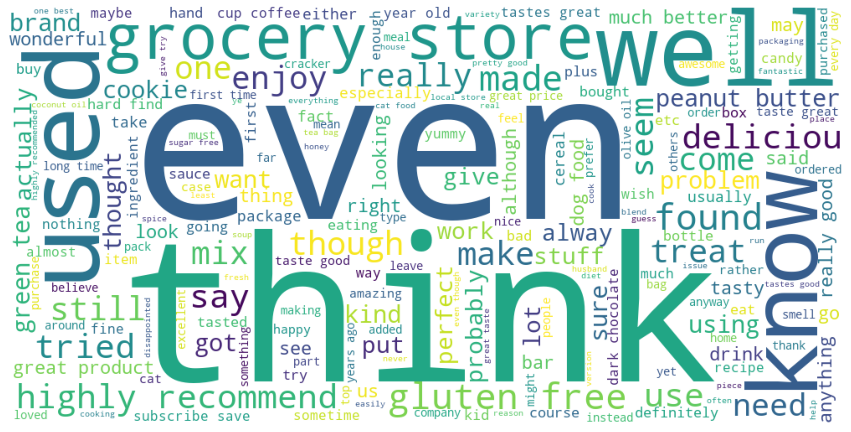

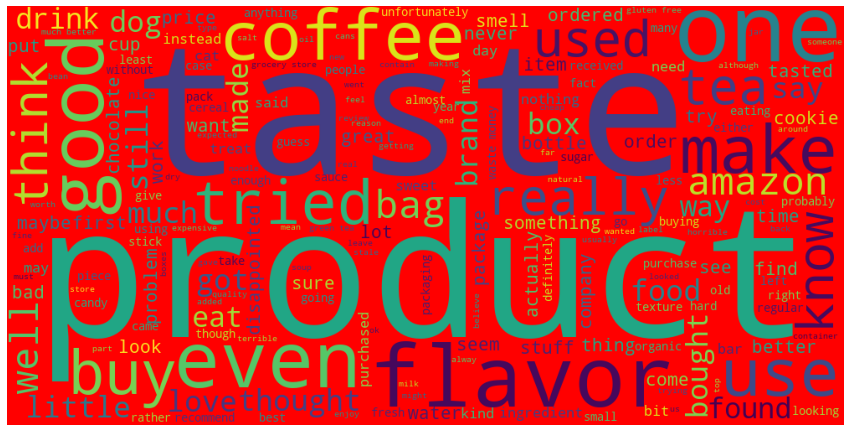

In [14]:
positive = df.loc[df.Score == 'positive'].Cleaned_Text.apply(lambda x: x.split()).tolist()
positive = " ".join([' '.join([str(word) for word in lst]) for lst in positive])

### Word CLoud
#Plot wordcloud
word_cloud = WordCloud(width = 1000, height = 500, background_color='white').generate(positive)

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

word_cloud.to_file('positive_words.png',)   #for saving file

print("="*100)

negative = df.loc[df.Score == 'negative'].Cleaned_Text.apply(lambda x: x.split()).tolist()
negative = " ".join([' '.join([str(word) for word in lst]) for lst in negative])

#Plot Negative wordcloud
word_cloud = WordCloud(width = 1000, height = 500, background_color='red').generate(negative)

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

word_cloud.to_file('negative_words.png')   #for saving file

In [15]:
from datetime import datetime
df['Time'] = df.Time.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['Time'] = pd.to_datetime(df.Time, dayfirst=True)
df['review_year'] = df.Time.apply(lambda x: x.year)
df['review_month'] = df.Time.apply(lambda x: x.month)

array([<AxesSubplot:title={'center':'negative'}>,
       <AxesSubplot:title={'center':'positive'}>], dtype=object)

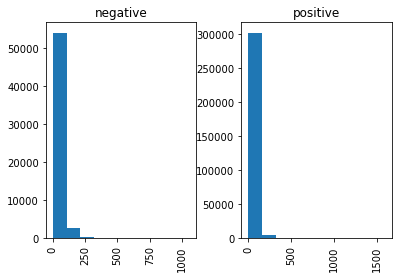

In [16]:
df.Len_Cleaned_Text.hist(by=df['Score'])

array([<AxesSubplot:title={'center':'negative'}>,
       <AxesSubplot:title={'center':'positive'}>], dtype=object)

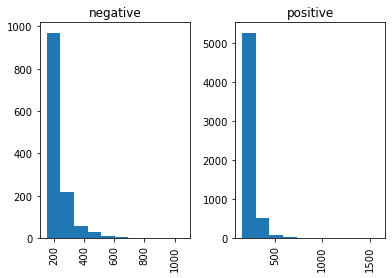

In [17]:
df.loc[df.Len_Cleaned_Text > 150].Len_Cleaned_Text.hist(by=df['Score']) 
## This seems to be looking good as we won't ran out of space during visualization of data

array([<AxesSubplot:title={'center':'negative'}>,
       <AxesSubplot:title={'center':'positive'}>], dtype=object)

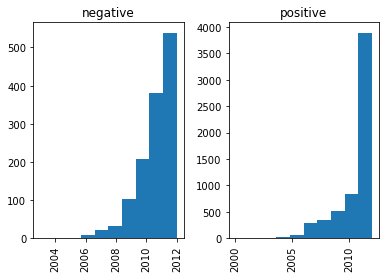

In [18]:
df.loc[(df.Len_Cleaned_Text > 150)].review_year.hist(by=df.Score)

In [19]:
conn = sqlite3.connect('./data/Preprocessed_Data.sqlite')
c = conn.cursor()
conn.text_factory = str
df.to_sql('Reviews', conn, schema=None, if_exists='replace')

# For ease of calculation / Here taking a sample of Data 

In [20]:
# Load Data 
conn = sqlite3.connect('./data/Preprocessed_Data.sqlite')
df = pd.read_sql_query("Select * from Reviews where Len_Cleaned_Text > 150;",conn)
df = df.drop('index',axis=1)
df.shape

(7255, 14)

> - # BOW

In [55]:
## BOW
#BoW
count_vect = CountVectorizer().fit(df.Cleaned_Text.values)
print("some feature names ", count_vect.get_feature_names()[:20])
print("-"*100)
#####################

df_bow = count_vect.fit_transform(df.Cleaned_Text.values)
print("the type of count vectorizer ",type(df_bow))
print("the shape of out text BOW vectorizer ",df_bow.get_shape())
print("the number of unique words ", df_bow.get_shape()[1])
print('Amount of Non-Zero occurences: ', df_bow.nnz)

print(f'sparsity: {(100.0 * df_bow.nnz / (df_bow.shape[0] * df_bow.shape[1]))}')

some feature names  ['aaaaaahhh', 'aaaaaahhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaawsome', 'aaaah', 'aaaand', 'aafco', 'aafes', 'aah', 'aahs', 'aalouisiana', 'aanother', 'aare', 'ab', 'aback', 'abamectin', 'abandned', 'abandon', 'abandoned', 'abandoning']
----------------------------------------------------------------------------------------------------
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7255, 43121)
the number of unique words  43121
Amount of Non-Zero occurences:  1102726
sparsity: 0.3524855953638449


> ### Applying TNSE on Text BOW vectors
> - t-SNE is applied on a dense matrix

In [56]:
# #### t-SNE Plot Function 
def plot_TSNE(ppty, loop, data_matrix, label, tech):
    model = TSNE(n_components=2, random_state=143, perplexity = ppty, n_iter=loop, n_jobs=-1)
    tsne_data = model.fit_transform(data_matrix)
    tsne_data = np.vstack((tsne_data.T, label)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
    sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title(f't-SNE on Text with {tech}')
    plt.show()

In [57]:
#converting sparse matrix to dense matrix 
#https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix/26577144
from sklearn.manifold import TSNE
import seaborn as sn

score=df['Score']
df_bow = df_bow.todense()

In [ ]:
# Bag of words --> Perplexisity = 50, iteration = 1000
plot_TSNE(50, 1000, df_bow, score, 'Bag of Words')

(7255, 3)

In [ ]:
df_bow = df_bow.todense()

> ### 2. Bigram, Ngram

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
df_bigram_counts = count_vect.fit_transform(df.Cleaned_Text.values)
print("the type of count vectorizer ",type(df_bigram_counts))
print("the shape of out text BOW vectorizer ",df_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", df_bigram_counts.get_shape()[1])

In [ ]:
print(count_vect.get_feature_names()[:20])

> ### 3. TF-IDF

<b>Term Frequency - Inverse Document Frequency. </b>

After the counting, the term weighting and normalization can be done with tf-idf

<b>TF: Term Frequency</b>, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

- <b>TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)</b>

<b>IDF: Inverse Document Frequency</b>, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

- <b>IDF(t) = log_e(Total number of documents / Number of documents with term t in it)</b>


In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(df.Cleaned_Text.values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(df.Cleaned_Text.values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

In [ ]:
features = tf_idf_vect.get_feature_names()

def top_tfidf_feat(row, features, top_n = 25):
    '''
        https://buhrmann.github.io/tfidf-analysis.html
        Top idf Features along values & words present in a single row
    '''
    top_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in top_ids]
    return pd.DataFrame(top_feats, columns=['feature', 'tfidf'])

top_tfidf_feat(final_tf_idf[1,:].toarray()[0], features)

> ### 4. Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
print(model['Computers'][:3])
print("="*50)
print(model.get_vector('Computers')[:3])
print('='*50)
model.most_similar('man')

In [ ]:
print(model.similarity('woman','man'))
model.most_similar('tasty')

In [ ]:
model.most_similar('tasti') # As if we stem tasty it will become tasti --> Which has no simmilar vector

> #### Training own word2vec model on Review Corpus

In [ ]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# https://radimrehurek.com/gensim/models/word2vec.html

# #  create a list of sentances
list_of_sentance = [i.split() for i in df.Cleaned_Text.values]

# # min_count = 5 considers only words that occured atleast 5 times
w2v_model = Word2Vec(list_of_sentance, min_count=5, vector_size=50, workers=4)
print(f'list of words {len(list(word2vec.wv.key_to_index))}')
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('bad'))

> ## Converting text into vectors using wAvg W2V, TFIDF-W2V
> - ### Avg W2v

In [ ]:
word_list = list(word2vec.wv.key_to_index.keys())
sentance_vectors = []
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in word_list:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sentance_vectors.append(sent_vec)
    
print(len(sentance_vectors))
print(len(sentance_vectors[0]))

In [ ]:
sentance_vectors[0]

> - ### TF_IDF Weighted Word2Vec

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(df.Cleaned_Text.values)
# we are converting a dictionary with word as a key, and the idf as a value
tfidf_dict = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_dict

word_list = list(word2vec.wv.key_to_index.keys())

sentance_vectors = []
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in word_list and word in tfidf_dict:
            vec = w2v_model.wv[word]
            tf_value = tfidf_dict[word]
            sent_vec += (vec * tf_value)
            weighted_sum += tf_value
    if weighted_sum > 0:
        sent_vec /= weighted_sum
    sentance_vectors.append(sent_vec)
    
print(len(sentance_vectors))
print(len(sentance_vectors[0]))
print('='*50)
sentance_vectors[0]

In [ ]:
import time

start_time = time.time()
print(f'time taken --> {time.time() - start_time}')

> #### t-SNE_Sample

In [ ]:
# https://github.com/pavlin-policar/fastTSNE
import numpy as np
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris['data'], iris['target']

tsne = TSNE( n_components=2, perplexity=25, learning_rate=150, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=2000)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()